In [0]:
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
import numpy as np
import subprocess
import json
import PIL
import os
from PIL import Image
import PIL.ImageOps
from matplotlib import cm
from google.colab import files
import shutil

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
from google.colab import drive
root_dir = '/content/drive/'
drive.mount(root_dir, force_remount = True)

Mounted at /content/drive/


In [4]:
base_dir = root_dir + 'My Drive/ML_Project/Dataset'

file_names = os.listdir(base_dir)
print(file_names)

['tree.npy', 't-shirt.npy', 'ice cream.npy', 'fish.npy', 'face.npy', 'car.npy', 'bowtie.npy', 'apple.npy', 'flamingo.npy', 'sheep.npy']


In [0]:
classes = ['tree.npy', 't-shirt.npy', 'ice cream.npy', 'fish.npy', 'face.npy', 'car.npy', 'bowtie.npy', 'apple.npy', 'flamingo.npy', 'sheep.npy']


## Utility Functions

In [0]:
def plot_samples(rows=5):
    num_classes = len(classes)
    '''
    Plots row number of samples from each class
    '''

    fig, axs = plt.subplots(figsize=(num_classes,rows))
    axs.axis('off')
    
    for i in range(rows * num_classes): 
        c = i % num_classes
        arr = np.load(f'{base_dir}/{classes[c]}')    
        # need to fix to put all classes in same column
        a = fig.add_subplot(rows, num_classes, i + 1)
        imgplot = plt.imshow(arr[i, :784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])



In [0]:
def load_from_gdrive():
    drive.mount('/content/drive/ML Project')
    # get list of files in ML Project / Dataset folder:
    #file_list = drive.ListFile(
    #{'q': "'1MP3lnyCnPrI2dPEa_prvTwWIw_UNnwcc' in parents"}).GetList()
    #print(file_list)

Download and load the data

Visualize classes


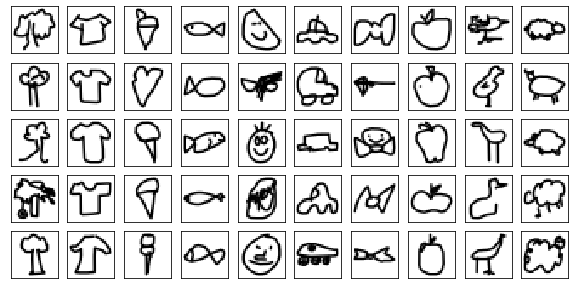

In [0]:
plot_samples()

In [0]:
def save_png(rows=5):
    num_classes = len(classes)
    '''
    Converts the npy array to png
    '''
    c = 1 #THE CLASS YOU WANT TO CONVERT
    arr = np.load(f'{root_dir}/My Drive/ML_Project/Dataset/{classes[c]}.npy')    

    print('CONVERTING CLASS ',classes[c])

    rows = len(arr)
    os.mkdir(classes[c])
    for i in range(rows): 
      inv_myarray = arr[i, :784].reshape((28,28))
      ones = np.ones((28,28))
      myarray = ones-inv_myarray
      im = Image.fromarray(np.uint8(cm.gray(myarray)*255)).convert('RGB')
      filename = classes[c]+'/img'+"{:07n}".format(i)+'.png'
      im.save(filename, "PNG")


In [0]:
save_png() #c is the class you want to convert. change the variable c in save_png. (c=0 -> apple).

CONVERTING CLASS  t-shirt


In [0]:
#DELETE FOLDER SINCE OS.MKDIR (IN FUNCTION SAVE_PNG) WILL NOT CREATE A FOLDER IF THERE 
#EXISTS A FOLDER WITH THE SPECIFIED NAME
#shutil.rmtree('./face')  

In [0]:
#DOWNLOAD THE FOLDER
!zip -r ./fish.zip ./fish/
#files.download("./face.zip") #faster to just download the zipped file from the toolbar on left

	zip warning: name not matched: ./fish/

zip error: Nothing to do! (try: zip -r ./fish.zip . -i ./fish/)


neural network helper functions

In [0]:
import math

# Calculates the height of the output of a 2D convolution
def calc_h_out(h_in, kernel_size, padding=0, dilation=1, stride=1):
    return math.floor(((h_in + 2 * padding - dilation * (kernel_size - 1) - 1)/stride) + 1)

# Calculates the width of the output of a 2D convolution
def calc_w_out(w_in, kernel_size, padding=0, dilation=1, stride=1):
    return math.floor(((w_in + 2 * padding - dilation * (kernel_size - 1) - 1)/stride) + 1)

## Supervised Learning: Sketch Classifier

In [0]:
class ClassifyNet(nn.Module):
    def __init__(self, num_classes):
        super(ClassifyNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(5)

        self.conv2 = nn.Conv2d(in_channels=5, out_channels= num_classes, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_classes)

        self.conv3 = nn.Conv2d(in_channels= num_classes, out_channels=num_classes, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(num_classes)
        self.mp = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(num_classes * 3 * 3, 60)
        self.fc2 = nn.Linear(60, num_classes)
    
    def forward(self):
        x = self.bn1(self.conv1(x))
        x = self.bn2(self.conv2(x))
        x = self.bn3(self.conv3(x))
        # Resize from (batch_size, num_classes, 3, 3) to (batch_size,num_classes*3*3)
        x = x.view(-1, num_classes * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

classifier = ClassifyNet(num_classes = 10)

Training the classifier:

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
trainloader = DataLoader(dataset = dataset, batch_size = 10)

num_epochs = 10

for epoch in range(num_epochs):
    avg_loss = 0.0

    for batch_idx, (xs, ys) in enumerate(trainloader):
        # reset stored gradients to 0
        optimizer.zero_grad()

        output = classifier.forward(xs)
        loss = criterion(output, ys)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    
    print(f'Avg training loss: {avg_loss / len(trainloader)}')

# save the weights


## Unsupervised learning: Variational Auto-Encoder

In [0]:
import torch
import torch.nn as nn
from torch.nn import functional as F
  
class VAE(nn.Module):
  def __init__(self, Nz):
    super(VAE, self).__init__()
    self.Nz = Nz
    #CNN: convert image to latent vector
    #self.conv1 = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)

    self.conv1 = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)
    #self.conv1 = torch.nn.Conv2d(3, 9, kernel_size=3, stride=1, padding=1)
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    self.conv2 = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)
    #self.conv2 = torch.nn.Conv2d(9, 18, kernel_size=3, stride=1, padding=1)
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    self.conv3 = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)
    #self.conv3 = torch.nn.Conv2d(18, 30, kernel_size=3, stride=1, padding=1)
    self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    self.fc1 = torch.nn.Linear(3 * 14 * 14, Nz)
    self.fc2 = torch.nn.Linear(3 * 14 * 14, Nz)

    #self.fc1 = torch.nn.Linear(3 * 7*7, Nz)
    #self.fc2 = torch.nn.Linear(3 * 7*7, Nz)

    #convert latent vector to image
    #self.l1 = nn.Linear(Nz, 14*14*3)

    self.l1 = nn.Linear(Nz, 14*14*3)
    self.up1 = nn.UpsamplingNearest2d(scale_factor=2)
    self.pad1 = nn.ReplicationPad2d(1)
    self.d_conv1 = nn.Conv2d(3, 3, 3, 1)
    
    self.sigmoid = nn.Sigmoid()

  def encode(self, image): #CNN, input: sketch, output: latent vector of size Nz.
    o1 = F.relu(self.conv1(image))
    o2 = F.relu(self.pool1(o1))

    #o2 = F.relu(self.conv2(o2))
    #o2 = F.relu(self.conv2(o2))
    #o4 = F.relu(self.pool2(o3))
    #print(o4.shape)

    o2 = o2.view(-1, 3 * 14 * 14)


    o7 = F.relu(self.fc1(o2))
    o8 = F.relu(self.fc2(o2))
    
    c1 = torch.isnan(torch.sum(o7))
    c2 = torch.isnan(torch.sum(o8))
    #print('FROM ENCODER',c1,c2)
    return o7, o8

  def decode(self, latent):
    #print('latent',latent.shape)
    o1 = F.relu(self.l1(latent))
    #print('o1', o1.shape)

    o1 = o1.view(-1, 3,14,14)

    #print('new o1',o1.shape)
    o2 = F.relu(self.pad1(self.up1(o1)))
    #print('o2', o2.shape)
    o3 = self.sigmoid(self.d_conv1(o2))
    #print('o3', o3.shape)

    c3 = torch.isnan(torch.sum(o3))
    c31 = torch.isnan(torch.sum(o1))
    c32 = torch.isnan(torch.sum(o2))
    c33 = torch.isnan(torch.sum(latent))
  
    #print('FROM DECODER',c3, c31, c32, c33)
    return o3

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    
    c4 = torch.isnan(torch.sum(std))
    c5 = torch.isnan(torch.sum(eps))
    #print('FROM REPARAMETERIZE', c4, c5)
    return mu + eps*std

  def forward(self, image):
    #flatten_np = np.reshape(image, (len(image),784*3))
    flatten = torch.from_numpy(image)
    #flatten = image.view(-1,784*4)
    mu, logvar = self.encode(flatten)
    lz = self.reparameterize(mu, logvar)
    #print('CHECK LATENT IN FORWARD', torch.isnan(torch.sum(lz)))
    im = self.decode(lz)

    c6 = torch.isnan(torch.sum(im))
    c7 = torch.isnan(torch.sum(mu))
    c8 = torch.isnan(torch.sum(logvar))
    #print('FROM FORWARD', c6,c7,c8)
    return im, mu, logvar


In [0]:
###----VISUALIZE IMAGES IN A FOLDER---------
import matplotlib.image as mpimg
def visualize_image(folder):
  count = 0
    
  for imagename in os.listdir(folder):
    filename = folder +'/'+imagename
    img = mpimg.imread(filename)
    imgplot = plt.imshow(img)
    plt.show()
    count += 1
    if count > 10:
      break
  

In [64]:
###-----CLASS TO GENERATE-------------
c = 9
arr = np.load(f'{root_dir}/My Drive/ML_Project/Dataset/{classes[c]}')    
print(classes[c])

sheep.npy


In [0]:
###-----LOAD TRAINING DATA AND LOSS FUNCTION----------
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.preprocessing import normalize

vae_model = VAE(1000)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

folder = 't-shirt'
train_data = []
count = 0

new_arr = np.copy(arr)

scaler = StandardScaler()
new_arr = scaler.fit_transform(new_arr)

#for imagename in os.listdir(folder):
for i in range(len(arr)):
  #filename = folder+'/'+imagename
  #img = mpimg.imread(filename)
  img = new_arr[i, :784].reshape((28,28))
  #print(img.shape)
  stacked_img = np.stack((img,)*3, axis=-1)
  p_img = np.zeros((3,28,28))
  p_img[0,:,:] = stacked_img[:,:,0]
  p_img[1,:,:] = stacked_img[:,:,1]
  p_img[2,:,:] = stacked_img[:,:,2]

  #norm2 = normalize(img, axis=0).ravel()
  #normed = p_img / np.linalg.norm(p_img)
  #py_pimg = torch.from_numpy(p_img)
  #n_img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(py_pimg)

  train_data.append(p_img)
  count += 1
  if count > 10000:
    break

def loss_function(z_img, img, mu, logvar):
  #z_img = z_img.data.numpy()
  img = torch.from_numpy(img)
  ts1 = torch.sum(z_img)
  ts2 = torch.sum(img)
  s1 = torch.isnan(ts1)
  s2 = torch.isnan(ts2)

  #print(img)
  #print('new',z_img.shape, img.shape, type(z_img), type(img))
  img = img.view(-1,28*28)
  BCE = F.binary_cross_entropy(z_img, img, reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE+KLD

In [66]:
###--------TRAINING------------------
epochs = 500
train_loss = 0
train_data = np.asarray(train_data, dtype=np.float32)

print(train_data.shape)

for epoch in range(epochs):
  optimizer.zero_grad()
  z_img, mu, logvar = vae_model(train_data)
  loss = loss_function(z_img, train_data, mu, logvar)
  loss.backward()
  train_loss = loss.item()
  optimizer.step()
  print('Epoch {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_data)))

(10001, 3, 28, 28)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Using a target size (torch.Size([30003, 784])) that is different to the input size (torch.Size([10001, 3, 28, 28])) is deprecated. Please ensure they have the same size.


Epoch 0 Average loss: 1753.1793
Epoch 1 Average loss: 1715.5820
Epoch 2 Average loss: 1704.8879
Epoch 3 Average loss: 1705.3385
Epoch 4 Average loss: 1659.7530
Epoch 5 Average loss: 1532.9217
Epoch 6 Average loss: 1372.9325
Epoch 7 Average loss: 1223.0569
Epoch 8 Average loss: 1119.1640
Epoch 9 Average loss: 1010.1082
Epoch 10 Average loss: 892.9584
Epoch 11 Average loss: 797.5640
Epoch 12 Average loss: 715.6612
Epoch 13 Average loss: 640.7647
Epoch 14 Average loss: 563.3164
Epoch 15 Average loss: 482.7160
Epoch 16 Average loss: 399.4303
Epoch 17 Average loss: 313.6530
Epoch 18 Average loss: 234.5577
Epoch 19 Average loss: 162.1954
Epoch 20 Average loss: 99.5036
Epoch 21 Average loss: 41.2484
Epoch 22 Average loss: -16.2133
Epoch 23 Average loss: -77.7724
Epoch 24 Average loss: -145.1350
Epoch 25 Average loss: -218.2886
Epoch 26 Average loss: -298.9403
Epoch 27 Average loss: -383.2401
Epoch 28 Average loss: -475.5061
Epoch 29 Average loss: -576.0572
Epoch 30 Average loss: -686.6252
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

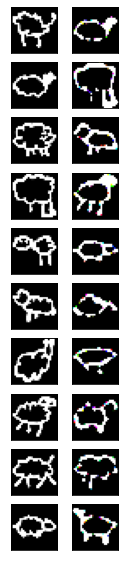

In [67]:
###-----COMPARE REAL (1ST COL) AND GENERATED (2ND COL) IMMAGES----------
generated = z_img.data.numpy()

rows = 10
fig, axs = plt.subplots(figsize=(2,rows))
axs.axis('off')

for i in range(2*rows):
  flag = i%2
  if flag == 0:
    img = train_data[round(i/2)]    
  else:
    img = generated[i,:,:,:]

  ds = np.zeros((28,28,3))
  ds[:,:,0] = img[0,:,:]
  ds[:,:,1] = img[1,:,:]
  ds[:,:,2] = img[2,:,:]
  a = fig.add_subplot(rows, 2, i + 1)
  imgplot = plt.imshow(ds*2)
  plt.xticks([])
  plt.yticks([])


In [0]:
###--------SAVE DATA----------------
car = np.zeros((len(generated),28*28))
for i in range(len(generated)):
  vector = generated[i,:,:,:]
  gray = vector[0,:,:]
  flat_gray = np.reshape(gray, (784))
  car[i,:] = flat_gray
filename = classes[c][:-4]+'_generated.npy'
np.save(filename, car)

10001


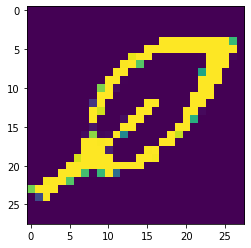

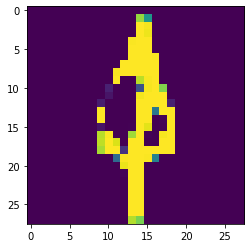

In [0]:
###-------LOAD DATA AND DISPLAY IT----------
car_gen = np.load(filename)
print(len(car_gen))
for i in range(2):
  vector = car_gen[i,:]
  img = np.reshape(vector,(28,28))
  plt.imshow(img)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


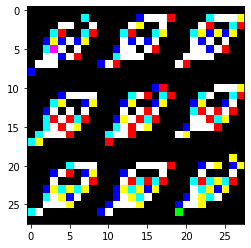

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


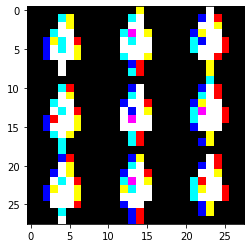

In [0]:
###--------SEE THE PRE-PROCESSED (NORMALIZED) DATA---------
for i in range(2):
  img = arr[i, :784].reshape((28,28))
  stacked_img = np.stack((img,)*3, axis=-1)

  p_img = np.zeros((3,28,28))
  p_img[0,:,:] = stacked_img[:,:,0]
  p_img[1,:,:] = stacked_img[:,:,1]
  p_img[2,:,:] = stacked_img[:,:,2]

  img = train_data[i]
  stacked_img = np.zeros((28,28,3))
  stacked_img[:,:,0] = p_img[0,:,:]
  stacked_img[:,:,1] = p_img[1,:,:]
  stacked_img[:,:,2] = p_img[2,:,:]

  stacked_img = np.reshape(img, (28,28,3))
  #py_pimg = torch.from_numpy(p_img)
  #n_img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(py_pimg)

  plt.imshow(stacked_img)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

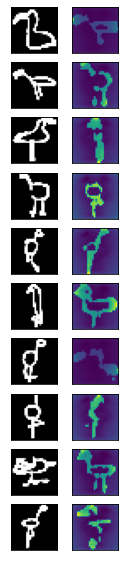

In [0]:
###-----COMPARE FROM NUMPY FILE-------
base_dir = root_dir + 'My Drive/ML_Project/VAE_outputs/'
generated = np.load(base_dir+classes[c]+'_generated.npy')

rows = 10
fig, axs = plt.subplots(figsize=(2,rows))
axs.axis('off')

scaler = StandardScaler()
generated = scaler.fit_transform(generated)

for i in range(2*rows):
  flag = i%2
  if flag == 0:
    img = train_data[round(i/2)]    
    ds = np.zeros((28,28,3))
    ds[:,:,0] = img[0,:,:]
    ds[:,:,1] = img[1,:,:]
    ds[:,:,2] = img[2,:,:]
  else:
    img = generated[i,:]
    ds = np.reshape(img, (28,28))
  a = fig.add_subplot(rows, 2, i + 1)
  imgplot = plt.imshow(ds*2)
  plt.xticks([])
  plt.yticks([])